# 파일 다운로드

In [ ]:
from tqdm.notebook import tqdm
import time
for i in tqdm(range(10)):
    time.sleep(0.5)

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1WNqV8300sC_q7jl11Tu3Ed3qlHvTIm5P --output data.zip

Downloading...
From: https://drive.google.com/uc?id=1WNqV8300sC_q7jl11Tu3Ed3qlHvTIm5P
To: /content/data.zip
100% 97.2k/97.2k [00:00<00:00, 35.4MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as existing_zip:
    existing_zip.extractall('data')

# **-필요 모듈 설치 및 Import**

In [ ]:
!pip install catboost
!pip install pycaret
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime as dt
from pycaret.regression import *

     |████████████████████████████████| 81kB 3.5MB/s 
ERROR: pandas-profiling 3.0.0 has requirement requests>=2.24.0, but you'll have requests 2.23.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


# **-데이터 로드 및 피쳐 생성**

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

print('done')

done


# **-변수 간 관계 시각화**

### **일-석식계 간 관계**

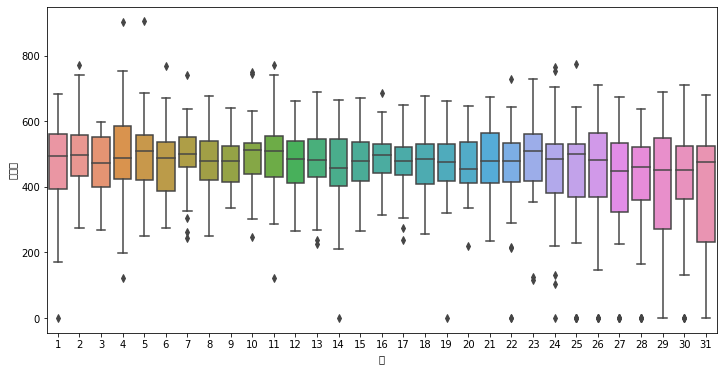

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(train['일'], train['석식계'])

## **주-석식계 간 관계**

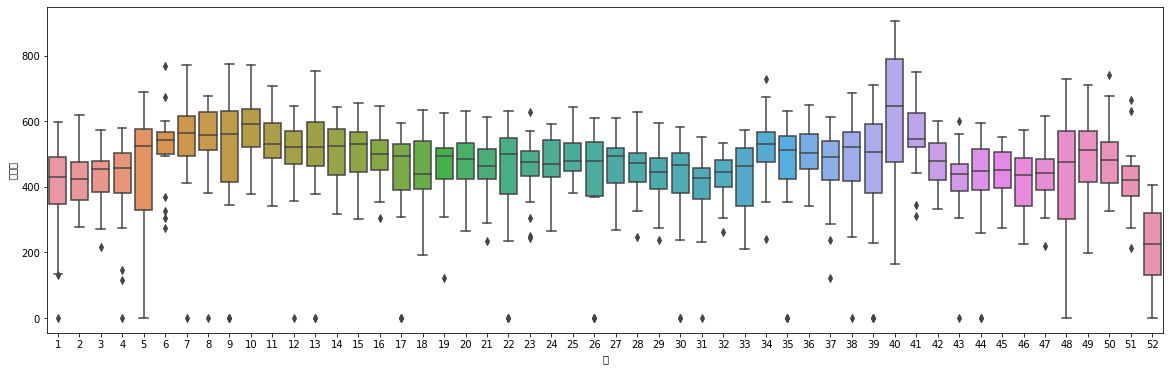

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(train['주'], train['석식계'])

## **월-석식계 간 관계**

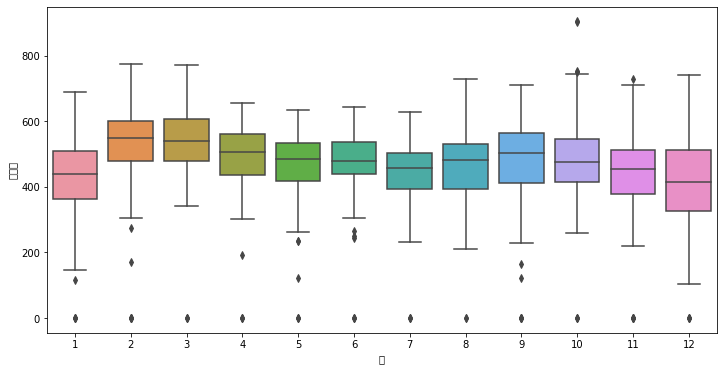

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(train['월'], train['석식계'])

## **년도-석식계 간 관계**

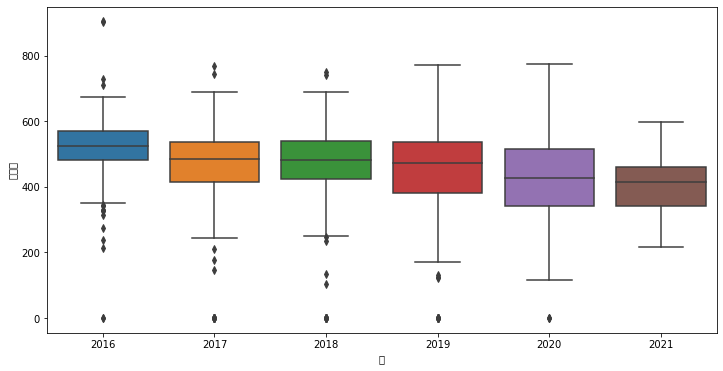

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(train['년'], train['석식계'])

## **야근인원수-석식계 간 관계**

<Figure size 864x432 with 0 Axes>

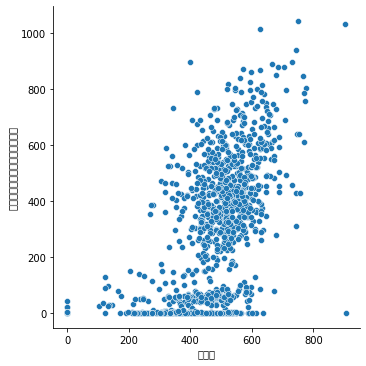

In [ ]:
plt.figure(figsize=(12,6))
sns.relplot(train['석식계'], train['본사시간외근무명령서승인건수'])

# **-NLP**

* **원핫인코딩으로 메뉴 분류하면 좋은 듯**

-------------------------------------------------------------

* **2021.06.12 기준**
* **메뉴의 종류를 원-핫 인코딩으로 분류시켜서 학습시키니 성능 상승**
* **'주' 및 '월' 데이터를 추가해서 연초 연말 월초 월말 알아서 학습 유도**

##**메뉴 임베딩**

In [ ]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [ ]:
test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [ ]:
train['중식메뉴_split'][0]

['오징어찌개', '잡곡밥', '청포묵무침', '요구르트', '포기김치', '쇠불고기', '쌀밥', '계란찜']

In [ ]:
lunch_lst = []
lunch_count = []
pref = 0
for i in tqdm(range(1205)):
  try:
    if train['중식계'][i] >= 880:
      pref = 1
    else:
      pref = 0

    lunch_lst.append(train['중식메뉴_split'][i])
    lunch_count.append(pref)
  except:
    pass
# for i in range(len(lunch_lst)):
  # lunch_lst[i] = lunch_lst[i].replace(',', ' ')
print('done')


done


In [ ]:
dinner_lst = []
dinner_count = []
pref_d = 0
for i in tqdm(range(1205)):
  try:
    if train['석식계'][i] > 476:
      pref_d = 1
    else:
      pref_d = 0

    dinner_lst.append(train['석식메뉴_split'][i])
    dinner_count.append(pref_d)
  except:
    pass
# for i in range(len(dinner_lst)):
#   dinner_lst[i] = dinner_lst[i].replace(',', ' ')
print('done')


done


In [ ]:
lunch_lst_test = []
lunch_count_test = []
for i in tqdm(range(50)):
  try:
    lunch_lst_test.append(test['중식메뉴_split'][i])
    lunch_count_test.append(0)
  except:
    pass
# for i in range(len(lunch_lst_test)):
#   lunch_lst_test[i] = lunch_lst_test[i].replace(',', ' ')
print('done')


done


In [ ]:
dinner_lst_test = []
dinner_count_test = []
for i in tqdm(range(50)):
  try:
    dinner_lst_test.append(test['석식메뉴_split'][i])
    dinner_count_test.append(0)
  except:
    pass
# for i in range(len(dinner_lst_test)):
#   dinner_lst_test[i] = dinner_lst_test[i].replace(',', ' ')
print('done')


done


In [ ]:
lunch_df = pd.DataFrame({'중식메뉴':lunch_lst})
dinner_df = pd.DataFrame({'석식메뉴':dinner_lst})
lunch_df_t = pd.DataFrame({'중식메뉴':lunch_lst_test})
dinner_df_t = pd.DataFrame({'석식메뉴':dinner_lst_test})

## **모든 메뉴의 분류**

In [ ]:
menu = pd.read_csv('/content/data/pinkcoding_data_menu.csv', encoding='cp949')

In [ ]:
food = list(menu['메뉴'])
result_lunch = []
result_dinner = []
for k in range(len(lunch_df)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(lunch_df.iloc[k][0])):
    if lunch_df.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == lunch_df.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_lunch.append(trigger)

for k in range(len(dinner_df)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(dinner_df.iloc[k][0])):
    if dinner_df.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == dinner_df.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_dinner.append(trigger)

In [ ]:
result_lunch_t = []
result_dinner_t = []
for k in range(len(lunch_df_t)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(lunch_df_t.iloc[k][0])):
    if lunch_df_t.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == lunch_df_t.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_lunch_t.append(trigger)

for k in range(len(dinner_df_t)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(dinner_df_t.iloc[k][0])):
    if dinner_df_t.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == dinner_df_t.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_dinner_t.append(trigger)

## **메뉴 데이터 생성**

In [ ]:
column = list(menu.columns[1:-1])
lunch_sort = pd.DataFrame(result_lunch ,columns=column)
dinner_sort = pd.DataFrame(result_dinner, columns = column)
lunch_sort_t = pd.DataFrame(result_lunch_t, columns=column)
dinner_sort_t = pd.DataFrame(result_dinner_t, columns = column)

# **-Feature Engineering**

## **공휴일 전후 데이터 추가**


*   테스트 데이터에 설날 연휴, 어린이날 존재
*   연휴 전날 1로 인코딩 나머지 0





In [ ]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

공휴일 지정 노가다....

In [ ]:
train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] =2
test['공휴일전후'][20] = 1

**원핫인코딩**

In [ ]:
train = pd.get_dummies(train, columns=['공휴일전후'])
test = pd.get_dummies(test, columns=['공휴일전후'])

In [ ]:
test['공휴일전후_0'][20] = 1
test['공휴일전후_1'][20] = 0

# **-Train Data Set & Test Data Set**

## **데이터 지정**

*   중식은 주52시간 탄련근무제에 영향 안받음
*   석식은 591번째 데이터 이후 (2018.07.01) 이후 부터 정의
*   메뉴 데이터 포함
----------------------------------------------------------------
*   탄력근무제 반영하지 않은 FULL 석식 데이터에서 더 높은 성능을 보임



In [ ]:
# -----------------------------<Full DATA>-----------------------------------

train_lunch = train[['요일','휴가비율','출장비율','재택비율', '출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']]
test_lunch = test[['요일','휴가비율','출장비율','재택비율','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

train_dinner = train[['요일','휴가비율','출장비율','재택비율', '출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']]
test_dinner = test[['요일','휴가비율','출장비율','재택비율', '출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]


#train_lunch = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']]
#test_lunch = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

#train_dinner = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']]
#test_dinner = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]

In [ ]:
# ------------------------<AFTER 2018.07.01 DATA>----------------------------

# train_1 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']][591:]
# test_1 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

# train_2 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']][591:]
# test_2 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]

In [ ]:
#메뉴
train_lunch = pd.concat([train_lunch, lunch_sort], axis = 1)
train_dinner = pd.concat([train_dinner, dinner_sort], axis = 1)
test_lunch = pd.concat([test_lunch, lunch_sort_t], axis = 1)
test_dinner = pd.concat([test_dinner, dinner_sort_t], axis = 1)
print('done')

done


## **중식 모델링**

In [ ]:
train_lunch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 50 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   요일           1205 non-null   int64  
 1   공휴일전후_0      1205 non-null   uint8  
 2   휴가비율         1205 non-null   float64
 3   출장비율         1205 non-null   float64
 4   재택비율         1205 non-null   float64
 5   공휴일전후_2      1205 non-null   uint8  
 6   공휴일전후_1      1205 non-null   uint8  
 7   출근           1205 non-null   int64  
 8   본사출장자수       1205 non-null   int64  
 9   현본사소속재택근무자수  1205 non-null   int64  
 10  본사휴가자수       1205 non-null   int64  
 11  일            1205 non-null   int64  
 12  주            1205 non-null   int64  
 13  월            1205 non-null   int64  
 14  년            1205 non-null   int64  
 15  중식계          1205 non-null   int64  
 16  곡류           1203 non-null   float64
 17  두류           1203 non-null   float64
 18  난류           1203 non-null   float64
 19  묵류    

In [ ]:
!pip install Catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [ ]:
X_data =train_lunch.drop(['중식계'],axis= 1)
y_data = train_lunch['중식계']

In [ ]:
train_x, val_x,train_y, val_y = train_test_split(X_data,y_data,test_size=0.3, random_state=42)
cat1 = CatBoostRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.01,depth = 10,loss_function='MAE')
cat1.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)

Index(['요일', '휴가비율', '출장비율', '재택비율', '출근', '본사출장자수', '현본사소속재택근무자수', '본사휴가자수',
       '일', '주', '월', '년', '곡류', '두류', '난류', '묵류', '어패류', '육류', '채소류', '해조류',
       '떡류', '양념.및.장류', '김치류', '만두류', '면류', '과일류', '밥류', '죽류', '덮밥국밥류',
       '비빔밥볶음밥류', '김.초.밥류', '국수류', '국탕류', '찌개류', '구이류', '무침류', '볶음류', '장아찌류',
       '전류', '조림류', '찜류', '튀김류', '샐러드류', '단품류', '유제품', '빵과자류'],
      dtype='object')


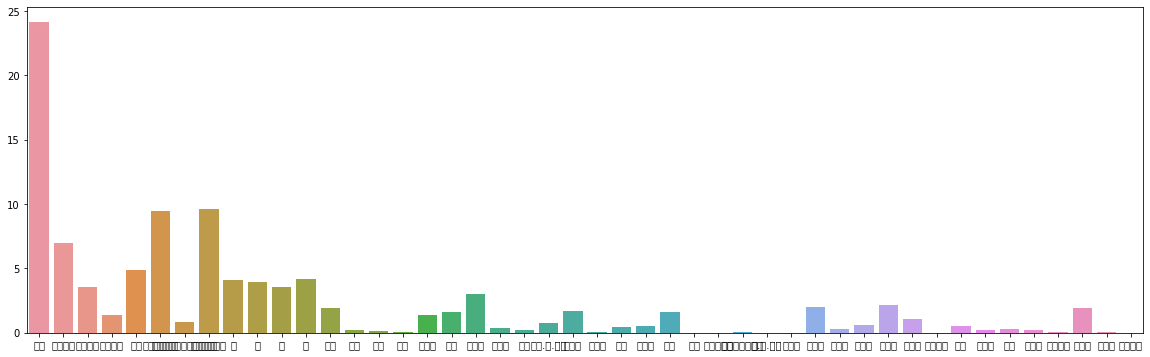

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

col = X_data.columns
FI = cat1.get_feature_importance()

print(X_data.columns)

plt.figure(figsize=(20,6))
sns.barplot(col,FI)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=10)
folds = []

for train_idx, valid_idx in kf.split(train):
    folds.append((train_idx, valid_idx))

In [ ]:
lunch_model = {}
target = '중식계'
for fold in range(10):
    print(f'===================================={fold+1}============================================')
    
    train_idx, valid_idx = folds[fold]
    train_x, val_x, train_y, val_y = train_lunch.drop([target],axis=1).iloc[train_idx], train_lunch.drop([target],axis=1).iloc[valid_idx],\
                                         train_lunch[target][train_idx], train_lunch[target][valid_idx] 
    cat = CatBoostRegressor(n_estimators=5000 ,random_seed=42, learning_rate=0.01,depth = 10,loss_function='MAE')
    cat.fit(train_x, train_y,
                  eval_set=[(train_x, train_y), (val_x, val_y)],
                  early_stopping_rounds=100,verbose=100)
    lunch_model[fold] = cat

====================================1============================================
0:	learn: 170.0577389	test: 170.0577389	test1: 132.5083461	best: 132.5083461 (0)	total: 39.7ms	remaining: 3m 18s
100:	learn: 95.8507745	test: 95.8507745	test1: 80.0712396	best: 80.0712396 (100)	total: 2.45s	remaining: 1m 58s
200:	learn: 67.9195371	test: 67.9195371	test1: 66.0510990	best: 66.0510990 (200)	total: 4.86s	remaining: 1m 56s
300:	learn: 54.0070233	test: 54.0070233	test1: 63.7712171	best: 63.7435719 (298)	total: 7.32s	remaining: 1m 54s
400:	learn: 45.4005261	test: 45.4005261	test1: 63.3186954	best: 63.2103317 (362)	total: 9.79s	remaining: 1m 52s
500:	learn: 39.6997618	test: 39.6997618	test1: 63.1420628	best: 62.9977630 (484)	total: 12.2s	remaining: 1m 49s
600:	learn: 34.8598369	test: 34.8598369	test1: 62.9560397	best: 62.9386733 (586)	total: 14.6s	remaining: 1m 47s
700:	learn: 31.0238324	test: 31.0238324	test1: 62.9689892	best: 62.8993605 (621)	total: 17.1s	remaining: 1m 44s
Stopped by overfittin

In [ ]:
reg = setup(data=train_lunch,
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,3733
1,Target,중식계
2,Original Data,"(1205, 47)"
3,Missing Values,True
4,Numeric Features,39
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 63)"


In [ ]:
best_5_l = compare_models(sort='MAE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,64.8632,7.160500e+03,83.7519,0.8346,0.1015,0.0779,4.208
gbr,Gradient Boosting Regressor,69.0350,8.186539e+03,89.6608,0.8110,0.1075,0.0821,0.250
huber,Huber Regressor,70.0579,9.348358e+03,95.4696,0.7850,0.1132,0.0828,0.075
ridge,Ridge Regression,71.8858,9.386318e+03,95.6606,0.7839,0.1147,0.0860,0.016
br,Bayesian Ridge,72.6418,9.464924e+03,96.0931,0.7820,0.1160,0.0872,0.021
lasso,Lasso Regression,72.7308,9.517896e+03,96.1997,0.7812,0.1164,0.0875,0.022
lightgbm,Light Gradient Boosting Machine,72.9218,9.266514e+03,94.9805,0.7867,0.1147,0.0873,0.150
et,Extra Trees Regressor,73.1371,9.533126e+03,96.1290,0.7800,0.1174,0.0879,0.867
rf,Random Forest Regressor,73.5844,9.512642e+03,96.4907,0.7807,0.1173,0.0884,1.059
omp,Orthogonal Matching Pursuit,75.6871,1.030073e+04,99.8704,0.7638,0.1212,0.0909,0.017


### **앙상블 모델**

In [ ]:
blended_l = blend_models(estimator_list= best_5_l, fold=10, optimize='MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_lunch)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,66.3762,7174.6942,84.7036,0.8408,0.0969,0.0766
1,59.3466,6734.0367,82.0612,0.8571,0.0951,0.0712
2,57.1309,5083.7471,71.3004,0.8678,0.0948,0.0725
3,53.3206,4648.5235,68.1801,0.8851,0.0801,0.0627
4,60.3811,5471.3660,73.9687,0.8491,0.0933,0.0724
5,68.8635,8677.9658,93.1556,0.7935,0.1065,0.0806
6,57.3935,5242.3578,72.4041,0.8749,0.0832,0.0669
7,74.3713,9814.2836,99.0671,0.8017,0.1330,0.0960
8,74.5739,10247.0550,101.2277,0.7711,0.1105,0.0831
9,77.6498,10719.6035,103.5355,0.7575,0.1186,0.0898


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,68.4883,8714.6033,93.352,0.8077,0.1228,0.0865


In [ ]:
pred_esb_l['Label']

0     1001.763474
1      880.554511
2      631.037521
3     1316.444006
4     1054.696515
5     1037.959494
6      998.699752
7      766.897316
8     1313.792324
9     1103.956160
10     850.850356
11    1305.527004
12    1109.366759
13    1097.267582
14     905.763119
15     734.779973
16    1253.432751
17    1039.712101
18     974.147116
19     891.372011
20     665.706553
21    1053.686919
22    1011.625115
23     921.692152
24     744.590221
25    1263.963607
26    1053.126506
27     998.023423
28     915.069617
29     755.745966
30    1273.302189
31    1051.931982
32    1079.768255
33     919.172857
34     688.575768
35    1254.299221
36     993.760867
37     945.264216
38     815.337110
39     636.734622
40    1231.018259
41    1012.003554
42     959.045702
43     841.865852
44     640.921183
45    1235.289612
46    1015.577038
47     994.114933
48     874.909860
49     640.327974
Name: Label, dtype: float64

In [ ]:
submission_esb = pd.read_csv('data/sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

## **석식 모델링**

In [ ]:
reg = setup(data=train_dinner,
            target='석식계', 
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,7769
1,Target,석식계
2,Original Data,"(1205, 48)"
3,Missing Values,True
4,Numeric Features,41
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 65)"


In [ ]:
best_5_d = compare_models(sort = 'MAE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,46.2959,4430.7533,65.6752,0.7354,0.5503,0.1063,4.866
et,Extra Trees Regressor,48.1324,4878.4234,69.0709,0.7046,0.3391,0.1121,0.871
rf,Random Forest Regressor,48.5016,4868.8855,69.1417,0.7032,0.2629,0.1145,1.082
huber,Huber Regressor,48.7456,4978.2857,69.7322,0.6950,0.5949,0.1112,0.076
lightgbm,Light Gradient Boosting Machine,48.7646,4942.2456,69.7321,0.6942,0.5033,0.1139,0.164
gbr,Gradient Boosting Regressor,48.8423,4705.7279,67.8909,0.7115,0.5776,0.1124,0.270
lr,Linear Regression,49.4111,4965.3674,69.6816,0.6940,0.6381,0.1117,0.017
ridge,Ridge Regression,49.7896,4874.7635,69.1378,0.6985,0.6748,0.1119,0.018
br,Bayesian Ridge,49.8064,4877.6618,69.1616,0.6984,0.6749,0.1119,0.022
lasso,Lasso Regression,52.2855,5293.8271,72.1363,0.6736,0.7005,0.1192,0.021


### 앙상블 모델

In [ ]:
blended_d = blend_models(estimator_list = best_5_d, fold = 10, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,47.5265,4883.7766,69.8840,0.5989,0.3701,0.1056
1,50.3634,4755.1741,68.9578,0.7352,0.5794,0.1097
2,36.2461,2169.2261,46.5750,0.8770,0.3754,0.0852
3,48.6068,5605.5716,74.8704,0.7582,0.4779,0.1190
4,48.9934,5402.0972,73.4990,0.6172,0.7654,0.0972
5,40.2768,3163.5335,56.2453,0.6398,0.1307,0.0940
6,46.7543,6187.0888,78.6580,0.6839,0.7904,0.1092
7,39.6648,2806.0419,52.9721,0.8087,0.3529,0.0810
8,48.5363,4768.6081,69.0551,0.8078,0.3819,0.1525
9,42.3327,3171.3814,56.3150,0.8633,0.5694,0.0952


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,41.9404,3521.1169,59.339,0.842,0.5886,0.1123


In [ ]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [ ]:
submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

,일자,중식계,석식계
0,2021-01-27,1001.763474,370.872646
1,2021-01-28,880.554511,452.237776
2,2021-01-29,631.037521,255.794411
3,2021-02-01,1316.444006,541.920164
4,2021-02-02,1054.696515,469.949196
5,2021-02-03,1037.959494,11.590588
6,2021-02-04,998.699752,468.517168
7,2021-02-05,766.897316,405.756523
8,2021-02-08,1313.792324,604.080934
9,2021-02-09,1103.956160,512.499525


In [ ]:
submission_esb.to_csv('submission2.csv', index = False)

# **간단한 시각화**

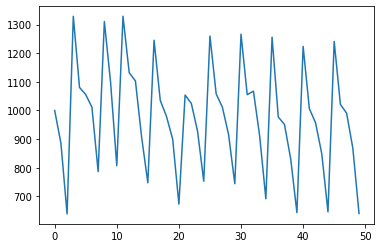

In [ ]:
submission_esb['중식계'].plot()

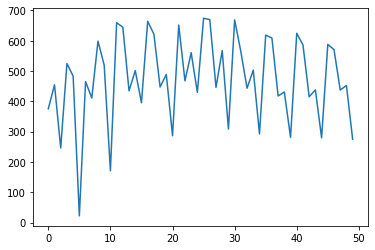

In [ ]:
submission_esb['석식계'].plot()